# Log Barrier Algorithm

## Define Convex problem and gradients and trajectory

In [179]:
##%matplotlib notebook
from matplotlib.patches import Polygon
import numpy as np
import matplotlib.pyplot as plt

#for a linear programming problem without equality constraints
c = np.array([2, 3])  # Coefficients in the objective function
A = np.array([[1, 1], [-1, 1], [-1, 0], [0, -1]])# Coefficients in the constraints
b = np.array([5, 3, 0, 0])# RHS values of the constraints
# Define the objective function, its gradient and hessian
def f(x):
    return c @ x
def grad_f(x):
    return c.T
def hess_f(X):
    return np.zeros((c.shape[0],c.shape[0]))

#-A@[t,t] or -A@[1,1]*t
#linear trajectory
def d(t):
    #direction = np.array([1, 1, -0.5, -0.5]) #to move all faces of polyhedron equally
    #return direction * t  # Linear trajectory
    return A@[t,t]

#quadratic trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * t**2
#sin wave trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * np.sin(t)

#exponential trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * np.exp(t)

# The inequality constraints are defined as g(x) <= 0
def g(x,t):
    return (A @ x.T).T - (b+d(t))
# Define the log barrier function and its gradient and hessian
def phi(x,k,t):
    return k * f(x) - np.sum(np.log(-g(x,t)))

def grad_phi(x,k,t):
    return k * grad_f(x) + A.T @ (1. / (-g(x,t)))

#def hessian_phi(x,k,t):
#    return k * hess_f(x) - np.sum(A.T @ np.diag((1. / g(x,t)**2)) @ A.T, axis=0) #ME to T stin parenthesi xoris diafora toso
def hessian_phi(x,k,t):
    n = x.shape[0]
    hessian =np.zeros((n,n))
    for a, val in zip(A, g(x,t)):
        hessian += -(1.0 /val**2) *np.outer(a, a) 
    return k * hess_f(x)+hessian



# Implementation of newton method and helper functions for visualization

In [181]:
from ipywidgets import interact, FloatSlider
import cvxpy as cp

def is_feasible(x):
    return np.all(g(x,t) <=0)

def backtracking(x, dx, t, k, alpha=0.2, beta=0.5):
    while not is_feasible(x + dx) or phi(x + dx, k, t) > phi(x, k, t) + alpha * grad_phi(x, k, t) @ dx:
        dx *= beta
    return dx


# Define the Newton method for optimization
def newton_method(x0, t, tol=1e-5, max_iter=100):
    x = x0
    k=0.2
    for _ in range(max_iter):
        grad = grad_phi(x,k,t)
        hessian = hessian_phi(x,k,t)
        #dx = -np.linalg.solve(hessian, grad) ,problem if not inverse
        dx = -np.linalg.lstsq(hessian, grad, rcond=None)[0]
        #dx = backtracking(x, dx, t, k)##didnt work
        if np.linalg.norm(dx) < tol or np.linalg.norm(hessian)<tol or np.linalg.norm(hessian)>1e10:
            break
        x += dx
    return x

def analytic_center(A, b):
    # Variables
    x = cp.Variable(A.shape[1])
    
    # Objective function
    objective = cp.Maximize(cp.sum(cp.log(b - A @ x)))
    
    # Problem
    problem = cp.Problem(objective)
    problem.solve()
    
    return x.value

# Function to plot trajectories
def plot_trajectories(t1, t2, t3):
    fig, ax = plt.subplots(figsize=(10,10))
    times = [t1, t2, t3]
    center_points=[]
    for t in times:
        # Generate points on the boundary of the polyhedron
        grid = np.linspace(-0.5, 50, 5000)
        xx, yy = np.meshgrid(grid, grid)
        xg = np.vstack((xx.ravel(), yy.ravel())).T
        ineqs = g(xg, t )  # here we normalize time back to your original scale
        in_poly = np.all(ineqs <= 0, axis=1)

        # Plot the polyhedron
        ax.scatter(xg[in_poly, 0], xg[in_poly, 1], s=1, alpha=0.3)
        
        #find and store the center 
        center = analytic_center(A, b+d(t))
        center_points.append(center)
        
        # Plot the optimal point
        opt_point = history[int(t*10)]
        ax.plot(opt_point[0], opt_point[1], 'ro')

        # Annotate the optimal value
        opt_value = f(opt_point)
        ax.annotate(f'Opt: {opt_value:.2f} at t={t}', (opt_point[0], opt_point[1]))

        
    ##draw the line connecting the center points
    center_points=np.array(center_points)
    for point in center_points:
        ax.plot(point[0], point[1], 'ko')
    ax.plot(center_points[:,0],center_points[:,1],'b--')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()



    


# Run the adaptive algorithm and visualize results

interactive(children=(FloatSlider(value=0.0, description='t1', max=20.0), FloatSlider(value=10.0, description=…

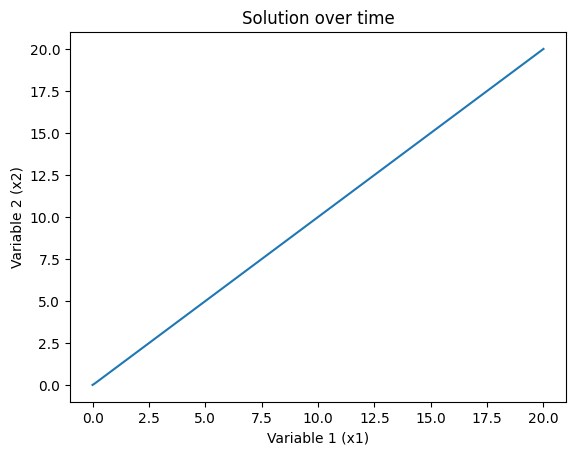

In [182]:
T=20
x0=np.array([0.5,0.5])
x=np.copy(x0)
history = []
#x0 = newton_method(x0, 0.1)
# Run the adaptive interior-point method and visualize the results
for t in np.arange(0, T+0.1 ,0.1):
    # Run the Newton method and update the history of optimal solutions
    x = newton_method(np.copy(x), t)
    history.append(x)
history = np.array(history)
# Widgets to interact with the plot
interact(plot_trajectories,
         t1=FloatSlider(min=0, max=T, step=0.1, value=0),
         t2=FloatSlider(min=0, max=T, step=0.1, value=T/2),
         t3=FloatSlider(min=0, max=T, step=0.1, value=T));

# Plot the solution over time
history = np.array(history)
plt.figure()
plt.plot(history[:, 0], history[:, 1])
plt.title('Solution over time')
plt.xlabel('Variable 1 (x1)')
plt.ylabel('Variable 2 (x2)')
plt.show()


# qudratic

In [ ]:
# Define the objective function, its gradient and hessian
def f(x):
    return x.T @ Q @ x + p.T @ x

def grad_f(x):
    return Q @ x + p

def hess_f(x):
    return Q
# Define the quadratic objective
Q = np.array([[2, 0], [0, 2]])
p = np.array([0, 0])


# Primal Dual Algorithm


## Define Convex problem and gradients and trajectory

In [217]:
##%matplotlib notebook
from matplotlib.patches import Polygon
import numpy as np
import matplotlib.pyplot as plt

c = np.array([2, 3])  # Coefficients in the objective function
A = np.array([[1, 1], [-1, 1], [-1, 0], [0, -1]])# Coefficients in the constraints
b = np.array([5, 3, 0, 0])# RHS values of the constraints
D=np.array([[2,0],[0,3]])
E=np.array([1,2])
# Define the objective function, its gradient and hessian,we change this and the arrays for different cost functions and constraints

def f(x):
    return c @ x
def grad_f(x):
    return c.T
def hess_f(X):
    return np.zeros((c.shape[0],c.shape[0]))

#linear trajectory
def d(t):
    #direction = np.array([1, 1, -0.5, -0.5]) #to move all faces of polyhedron equally
    #return direction * t  # Linear trajectory
    return A@[t,t]

#quadratic trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * t**2
#sin wave trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * np.sin(t)

#exponential trajectory
#def d(t):
#    direction = np.array([1, 1, 0, 0])  # Adjust as needed.
#    return direction * np.exp(t)

# The equality constraints are defined as j(x) == 0
def j(x,t):
    return D@x -E

# The inequality constraints are defined as g(x) <= 0
def g(x,t):
    return (A @ x.T).T - (b+d(t))
def grad_g(x):
    return A
# Define the log barrier function and its gradient and hessian
def phi(x,λ,ν,t):
    return f(x) + λ @ g(x,t) +ν.T @ j(x,t)

def grad_phi(x,λ,ν,t):
    return grad_f(x) + grad_g(x,t).T @ λ + D.T@ν 

def hessian(x, t, λ, v):
    H = np.eye(2)*0  # Hessian of the objective function
    for i in range(len(λ)):
        H += λ[i] * grad_g(x)[i].reshape(-1, 1) @ grad_g(x)[i].reshape(-1, 1).T
    return H


# Implementation of newton method and helper functions for visualization

In [218]:
# Define the Adaptive Primal-Dual Interior Point Method

def primal_dual(x0, λ0, ν0, t,μ=10,alpha=0.01,beta=0.5, tol=1e-8, max_iter=10):
    x, ν, λ = x0, ν0, λ0
    m=A.shape[0] #number of inequality constraints
    n=D.shape[0]#number of equality constraints
    N=A.shape[1]#number of variables
    for _ in range(max_iter):
        
        #surrogate duality gap
        h=-g(x,t)*λ
        k=μ*m/h
        
        # Compute the residuals
        rdual = grad_f(x) + grad_g(x).T @ λ + D.T@ν
        rcent = -np.diag(λ) @g(x,t).T -(1/k)
        rprimal=D @ x -E
        residuals=np.concatenate([rdual,rcent,rprimal])
        
        # Formulate the Newton system
        M1 = np.block([[hess_f(x), grad_g(x).T, D.T], [-np.diag(λ)@grad_g(x), -np.diag(g(x,t)), np.zeros((m, n))], [D, np.zeros((n, m)), np.zeros((n, n))]])
        M2 = residuals
        sol = np.linalg.lstsq(M1, M2, rcond=None)[0]
        
        # Extract dx, dy, dλ from the solution
        dx = sol[:N]
        dλ = sol[N:N+m]
        dν = sol[N+m:]
        # Perform line search(backtracking) and update x, λ, ν
        #smax = np.minimum(np.amin([-λ[i]/dλ[i] for i in range(m) if dλ[i] < 0]), 1)
        #smax=np.amin(1, np.amin(-λ[dλ < 0] / dλ[dλ < 0]))
        smax=1
        for i in range(m):
            if dλ[i]<0:
                if smax>-λ[i]/dλ[i]:
                    smax=-λ[i]/dλ[i]
        s = 0.99 * smax
        while True:
            x_new = x + s * dx
            λ_new = λ + s * dλ
            ν_new = ν + s * dν
            rdual = grad_f(x_new) + grad_g(x_new).T @ λ_new + D.T@ν_new
            rcent = -np.diag(λ_new) @g(x_new,t).T -(1/k)
            rprimal=D @ x_new -E
            new_residuals=np.concatenate([rdual,rcent,rprimal])
            if np.linalg.norm(new_residuals)<=(1-alpha*s)*np.linalg.norm(residuals):#or np.min(x_new) > 0 and np.min(s_new) > 0 and np.dot(x_new, s_new) < 0.9 * mu:
                break
            s *=beta
        # Update primal and dual variables
        x, λ, ν = x_new, λ_new, ν_new

        # Check the convergence
        if np.linalg.norm(rdual)<tol or np.linalg.norm(rprimal)<tol or np.linalg.norm(h)<tol or np.linalg.norm(dx) < tol or np.linalg.norm(dλ) < tol :
            break


    return x, λ, ν

def analytic_center(A, b):
    # Variables
    x = cp.Variable(A.shape[1])
    
    # Objective function
    objective = cp.Maximize(cp.sum(cp.log(b - A @ x)))
    
    # Problem
    problem = cp.Problem(objective)
    problem.solve()
    
    return x.value

# Function to plot trajectories
def plot_trajectories(t1, t2, t3):
    fig, ax = plt.subplots(figsize=(10,10))
    times = [t1, t2, t3]
    center_points=[]
    for t in times:
        # Generate points on the boundary of the polyhedron
        grid = np.linspace(-0.5, 50, 5000)
        xx, yy = np.meshgrid(grid, grid)
        xg = np.vstack((xx.ravel(), yy.ravel())).T
        ineqs = g(xg, t )  # here we normalize time back to your original scale
        in_poly = np.all(ineqs <= 0, axis=1)

        # Plot the polyhedron
        ax.scatter(xg[in_poly, 0], xg[in_poly, 1], s=1, alpha=0.3)
        
        #find and store the center 
        center = analytic_center(A, b+d(t))
        center_points.append(center)
        
        # Plot the optimal point
        opt_point = history[int(t*10)]
        ax.plot(opt_point[0], opt_point[1], 'ro')

        # Annotate the optimal value
        opt_value = f(opt_point)
        ax.annotate(f'Opt: {opt_value:.2f} at t={t}', (opt_point[0], opt_point[1]))

        
    ##draw the line connecting the center points
    center_points=np.array(center_points)
    for point in center_points:
        ax.plot(point[0], point[1], 'ko')
    ax.plot(center_points[:,0],center_points[:,1],'b--')
    ax.set_xlabel('x1')
    ax.set_ylabel('x2')
    plt.show()





# Run the adaptive algorithm and visualize results

C:\Users\mdado\AppData\Local\Temp\ipykernel_23924\2008646167.py:12: RuntimeWarning: divide by zero encountered in true_divide
  k=μ*m/h


interactive(children=(FloatSlider(value=0.0, description='t1', max=20.0), FloatSlider(value=10.0, description=…

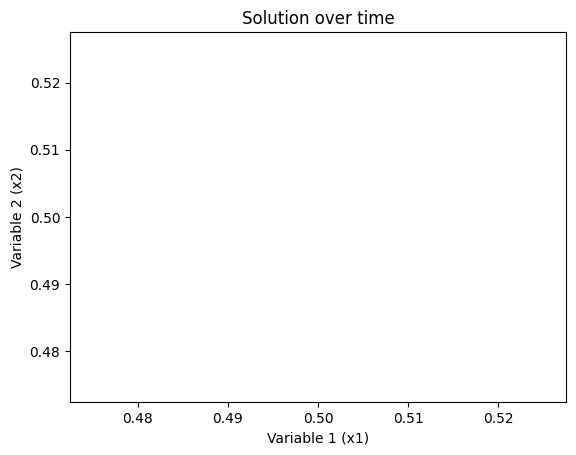

In [219]:
T=20
# Initial guess
x0=np.array([0.5,0.5])
ν0 = np.zeros(D.shape[0])
λ0 = np.ones(A.shape[0])
x=np.copy(x0)
λ=np.copy(λ0)
ν=np.copy(ν0)
history = []
# Run the adaptive interior-point method and visualize the results
for t in np.arange(0, T+0.1 ,0.1):
    # Run the primal dual method and update the history of optimal solutions
    x,λ,ν = primal_dual(np.copy(x),np.copy(λ),np.copy(ν), t)
    history.append(x)
history = np.array(history)
# Widgets to interact with the plot
interact(plot_trajectories,
         t1=FloatSlider(min=0, max=T, step=0.1, value=0),
         t2=FloatSlider(min=0, max=T, step=0.1, value=T/2),
         t3=FloatSlider(min=0, max=T, step=0.1, value=T));

# Plot the solution over time
history = np.array(history)
plt.figure()
plt.plot(history[:, 0], history[:, 1])
plt.title('Solution over time')
plt.xlabel('Variable 1 (x1)')
plt.ylabel('Variable 2 (x2)')
plt.show()